# 3.4 Softmax Regression

Regression is the hammer that we reach for when we want to answer:
- *how much?*
- *how many?*

types of questions. If you want to predict the number of dollars (the *price*) at which a house will be sold, or the number of wins a baseball team might have, or the number of days that a patient will remain hospitalized before being discharged, then you are probabily looking for a regression model.

#### 3.4.1 Classification Problems

To get our feet wet, let's start off with a simple image classification problem. Here, each input consists of a $2 x 2$ grayscale image. We can represent each pixel value with a single scalar, giving us four features $x_1, x_2, x_3, x_4$. Further, let's assume that each image belongs to one among categories "cat", "chicken", "dog".

Next, we have to choose how to represent the labels. We have two obvious choices. Perhaps the most natural impulse would be to choose $y \in \{1,2,3\}$, where the integers represent {dog, cat, chicken}, respectively. This is a great way of storing such information on a computer. If the categories have some natural ordering among them, say if we were trying to predict {baby, toddler, adolescent, young adult, adult, geriatric}, then it might even make sense to cast this problem as regression and keep the labels in this format.

But general classification problems do not come with natural orderings among the classes. Fortunately, statisticians long ago invented a simple way to represent categorical data: the *one hot encoding*. A one-hot encoding is a vector with as many components as we have categories. The component corresponding to a particular instance's category is set to 1 and all other components are set to 0.
- $y \in \{(1,0,0),(0,1,0),(0,0,1)\}$

In our case, $y$ would be a three-dimensional vector, with (1,0,0) corresponding to a "cat", (0,1,0) to "chicken" and (0,0,1) to "dog".

#### Network Architecture

In order to estimate the conditional probabilities associated with each classes, we need a model with multiple outputs, one per class. **To address classification with linear models, we will need as many linear functions as we have outputs. Each output will correspond to its own linear function**. In our case, since we have 4 features and 3 possible output categories, we will need 12 scalars to represent the weights, ($w$ with subscripts) and 3 scalars to represent the biases ($b$ with subscripts). We compute these three *logits*, $o_1, o_2$, and $o_3$, for each input:

- $o_1 = x_1w_{11} + x_2w_{12} + x_3w_{13} + x_4w_{14}$
- $o_2 = x_1w_{21} + x_2w_{22} + x_3w_{23} + x_4w_{24}$
- $o_3 = x_1w_{31} + x_2w_{32} + x_3w_{33} + x_4w_{34}$

We can depict this calculation with a typical neural network diagram, where each node in the input layer is connected to each of the three outputs (in the output layer). Just as in linear regression, softmax regression is also a single-layer NN. And since the calculation of each output $o_1, o_2$, and $o_3$ depends on all inputs $x_1, x_2, x_3$, and $x_4$, the output layer of softmax regression can also be described as fully-connected layer.

To express the model more compactly, we can use linear algebra notation. In vector form, we arrive at,
- $\textbf {o = Wx + b}$

which is a form better suited both for mathematics, and for writing code. Note that we have gathered all of our weights into a $3 x 4$ matrix and that for a given example $\textbf{x}$, our outputs are given by a matrix-vector product of our weights by our inputs plus our biases $\textbf{b}$

#### Softmax Operation

The main approach that we are going to take here is to interpret the outputs of our model as **probabilities**. We will optimize our parameters to produce probabilities that maximize the likelihood of the observed data. Then, to generate predictions, we will set a threshold, for example, choosing the *argmax* of the predicted probabilities.

Put formally, we would like outputs $\hat{y_k}$ that we can interpret as probability that a given item belongs to class $k$. Then we can choose the class with the largest output value as our prediction $argmax_ky_k$. For example, if $\hat{y_1}, \hat{y_2}$, and $\hat{y_3}$ are 0.1, 0.8, and 0.1, respectively, then we predict category 2, which in our example represents "chicken". 

You might be tempted to suggest that we interpret the logits $o$ directly as our outputs of interest. However, there are some problems with directly interpreting the output of the linear layer as a probability. Nothing constrains these numbers to sum to 1. Moreover, depending on the inputs, they can take negative values. These violate basic axioms of probability presented in earlier notebook on probability.

To represent our outputs as probabilities, we must guarantee that (even on new data), they will be nonnegative and sum up to 1. Moreover, we need a training objective that encourages the model to estimate faithfully *probabilities*. Of all instances when a classifier outputs 0.5, we hope that half of those examples will *actually* belong to the predicted class. This is a property known as *calibration*.

The *softmax function*, invented in 1959 by the social scientist R Duncan Luce in the context of *choice models* does precisely this. To transform our logits such that they become nonnegative and sum up to 1, while requiring that the model remains differentiable, we first exponentiate each logit (ensuring non-negativity) and then divide by their sum (ensuring that they sum up to 1).

- $\hat{y} = softmax(\textbf{o})$ where $\hat{y_i} = \frac{exp(o_i)}{\sum{exp(o_j)}}$

It is easy to see that $\hat{y_1} + \hat{y_2} + \hat{y_3} = 1$ with $0 \leq \hat{y_i} \leq 1$ for all $i$. Thus, $\hat{y}$ is a proper probability distribution and the values of $\hat{\textbf{y}}$ can be interpreted accordingly. Note that the softmax operation does not change the ordering among the logits, and thus we can still pick out the most likely class by:

- $\hat{i}(\textbf{o}) = argmaxo_i = argmax\hat{y_i}$

The logits $\textbf{o}$ then are simply the pre-softmax values that are determining the probabilities assigned for each category. Summarizing it all in a vector notation we get $\textbf{o}^{(i)} = Wx^{(i)} + b$, where $\hat{\textbf{y}}^{(i)} = softmax(o^{(i)})$

#### Vectorization for Minibatches

### 3.5 The Image Classification Dataset (Fashion MNIST)

In [27]:
import matplotlib.pyplot as plt

In [28]:
%matplotlib inline
import d2l
from mxnet import gluon
import sys

d2l.use_svg_display()

#### 3.5.1 Getting the Dataset

In [29]:
mnist_train = gluon.data.vision.FashionMNIST(train = True)
mnist_test = gluon.data.vision.FashionMNIST(train = False)

The FashionMNIST dataset consists of images from 10 categories, each represented by 6k images in the training set and by 1k in the test set. Consequently, the training set and the test set contain 60k and 10k images, respectively

In [30]:
len(mnist_train), len(mnist_test)

(60000, 10000)

The images in the FashionMNIST are associated with the following categories: t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot. The following function converts between numeric label indices and their names in text

In [31]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'drees', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [32]:
def show_images(imgs, num_rows, num_cols, titles = None, scale = 1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
            
    return axes

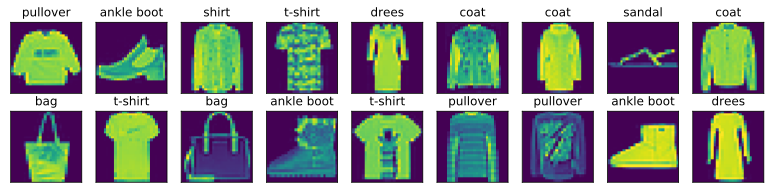

In [33]:
X, y = mnist_train[:18]
show_images(X.squeeze(axis = -1), 2, 9, titles = get_fashion_mnist_labels(y))
plt.show()

#### 3.5.2 Reading a Minibatch

To make our life easier when reading from the training and test sets, we use a DataLoader rather than creating one from scratch. Recall that at each iteration, a DataLoader reads a minibatch of data with size `batch_size` each time.

During training, reading data can be a significant performance bottleneck, especially when our model is simple or when our computer is fast. A handy feature of Gluon's DataLoader is the ability to use multiple processes to speed up data reading. For instance, we can set aside 4 processes to read the data (via `num_workers`).

In [34]:
def get_dataloader_workers(num_workers = 4):
    if sys.platform.startswith('win'):
        return 0
    else:
        return num_workers

Below, we convert the image data from uint8 to 32-bit floating point numbers using the `ToTensor` class. Additionally, the transformer will divide all numbers by 255 so that all pixels have values between 0 and 1. The `ToTensor` class also moves the image channel from the last dimension to the first dimension to facilitate the CNN calculations introduced later (basically, from what I know/encountered is that when working with image data you get a tuple like this (200,160,3) which translates to 210 height, width, and channels. Usually, a CNN needs channels as a first value, so we end up with (3,200,160)). Through the `transform_first` function of the dataset, we apply the transformation of `ToTensor` to the first element of each instance (image and label)

In [35]:
batch_size = 256
transformer = gluon.data.vision.transforms.ToTensor()
train_iter = gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                   batch_size, shuffle=True,
                                   num_workers=get_dataloader_workers())

In [36]:
timer = d2l.Timer()

for X, y in train_iter:
    continue
'%.2f sec' % timer.stop()

'2.37 sec'

#### 3.5.3 Putting All Things Together

Now we define the `load_data_fashion_mnist` function that obtains and reads the Fashion-MNIST dataset. It returns the data iterators for both the training set and validation set. In addition, it accepts an optional argument to resize images to another shape.

In [37]:
def load_data_fashion_mnist(batch_size, resize = None):
    dataset = gluon.data.vision
    trans = [dataset.transforms.Resize(resize)] if resize else []
    trans.append(dataset.transforms.ToTensor())
    trans = dataset.transforms.Compose(trans)
    mnist_train = dataset.FashionMNIST(train = True).transform_first(trans)
    mnist_test = dataset.FashionMNIST(train = False).transform_first(trans)
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle = True,
                                 num_workers=get_dataloader_workers()),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                  num_workers=get_dataloader_workers()))

In [38]:
# resizing an image
train_iter, test_iter = load_data_fashion_mnist(32, (64, 64))

for X,y in train_iter:
    print(X.shape)
    break

(32, 1, 64, 64)


## 3.6 Implementation of Softmax Regression from Scratch

Just as we implemented linear regression from scratch, we believe that multiclass logistic (softmax) regression is similarly fundamental and you ought to know the gory details of how to implement it yourself. We'll start off with the from scratch implementation and then go to the Gluon way of doing things.

In [39]:
# importing the important packages
import d2l
from mxnet import autograd, np, npx, gluon
from IPython import display

npx.set_np()

We will work with the Fashion-MNIST dataset, introduced above, setting up an iterator with batch size 256

In [40]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [41]:
for X, y in train_iter:
    print(X.shape)
    break
    
# batch_size, channel, height, width

(256, 1, 28, 28)


#### 3.6.1 Initializing Model Parameters

As in our linear regression example, each example here will be represented by a fixed-length vector. Each example in the raw data is 28 x 28 image. In this section, **we will flatten each image**, treating them as 784 1D vectors. In the future, we will talk about more sophisticated strategies for exploiting the spatial structure in images, but **for now we treat each pixel location as just another feature**.

Recall that in softmax regression, **we have as many outputs as there are categories**. Because our dataset has 10 categories, our network will have an output dimension of 10. Consequently, our weights will constitute a 784 x 10 matrix and the biases will constitute 1 x 10 vector. As with linear regression, we will initialize our weights W with Gaussian noise and our biases to take the initial value of 0.

In [42]:
num_inputs = 28 * 28
num_outputs = 10 # 10 unique categories for clothes

W = np.random.normal(0, 0.01, (num_inputs, num_outputs))
b = np.zeros(num_outputs)

Recall that we need to *attach gradients* to the model parameters. More literally, we are allocating memory for future gradients to be stored and notifying MXNet that we will want to calculate gradients with respect to these parameters in the future.

In [43]:
W.attach_grad()
b.attach_grad()

#### 3.6.2 The Softmax

Before implementing the softmax regression model, let's briefly review how operators such as `sum` work along specific dimensions in an `ndarray`. Given a matrix `X` we can sum over all elements (default) or only over elements in the same axis, i.e., the column (axis = 0) or the same row (axis = 1). Note that if X is an array with shape (2,3) and we sum over the columns (`X.sum(axis = 0`, the result will be a 1D vector with shape (3,)). **If we want to keep the number of axes in the original array (resulting in a 2D array with shape (1,3)), rather than collapsing out the dimension that we summed over we can specify** `keepdims = True` when invoking `sum`.

In [44]:
X_matrix = np.array([[1,2,3],
                     [4,5,6]])
X_matrix

array([[1., 2., 3.],
       [4., 5., 6.]])

In [45]:
print(X_matrix.sum(axis = 0, keepdims=True), '\n', 
      X_matrix.sum(axis = 1, keepdims=True))

[[5. 7. 9.]] 
 [[ 6.]
 [15.]]


We are now ready to implement the softmax function. Recall that softmax consists of two steps:

- 1) We exponentiate each term using `exp`.
- 2) We sum over **each row** (we have one row per example in the batch) to get the normalization constants for each example. Finally, we divide each row by its normalization constant, ensuring that the result sums up to 1.

In [46]:
def softmax(X):
    X_exp = np.exp(X)
    partition = X_exp.sum(axis = 1, keepdims = True)
    
    return X_exp / partition

As you can see, for any random input, we turn each element into a non-negative number. Moreover, each row sums up to 1, as is required for probability. Note that while this looks correct mathematically, we were a bit sloppy in our implementation because **we failed to take precautions against numerical overflow or underflow due to large (or very small) elements of the matrix**.

In [47]:
X = np.random.normal(size = (2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis = 1)

(array([[0.10138504, 0.03572102, 0.04586977, 0.67316556, 0.1438586 ],
        [0.03605377, 0.05437361, 0.6059516 , 0.08428083, 0.2193402 ]]),
 array([1., 1.]))

#### 3.6.3 The Model

Now that we have defined the softmax operation, we can implement the softmax regression model. The below code defines the forward pass through the network. Note that we **flatten each original image in the batch into a vector with length** `num_inputs` **with the reshape function before passing the data through our model**.

In [48]:
def net(X):
    return softmax(np.dot(X.reshape(-1, num_inputs), W) + b)

#### 3.6.4 The Loss Function

Next, we need to implement the cross-entropy loss function, introduced earlier. This may be the most common loss function in all of deep learning because, at the moment, classification problems far outnumber regression problems.

Recall that cross-entropy takes the **negative log likelihood** of the predicted probability assigned to the true label $-log P(y | x)$. Rather than iterating over the predictions with a Python for loop (which tends to be inefficient), we can use the `pick` function which allows us to easily select the appropriate terms from the matrix of softmax entries. Below we illustrate the `pick` function on a toy example, with 3 categories and 2 observations.

In [49]:
y_hat = np.array([[0.1, 0.3, 0.6],
                  [0.3, 0.2, 0.5]])

y_hat[[0,1], [0,2]]

array([0.1, 0.5])

Here's an in detail explanation of how the pick function works (taken from the official forum of the book)

In this example, we choose elements using slices; [0, 1] refers to the elements along axis 1 (the first and the second rows) and [0, 2] along axis 0 (the first and the third columns). Therefore, we obtain an array containing y_hat[0, 0] and y_hat[1, 2].

**Note:** There is no such thing as a `pick` function in NumPy, the example above illustrates the mechanics of such function in use. 

Now we can implement the cross-entropy loss function efficiently with just one line of code.

In [50]:
def cross_entropy(y_hat, y):
    return -np.log(y_hat[range(len(y_hat)), y])

#### 3.6.5 Classification Accuracy

Given the predicted probability distribution `y_hat`, we typically choose the class with the highest predicted probability whenever we must output a *hard* prediction. Indeed, many applications require that we make a choice. Gmail must categorize an email into Primary, Social, Updates, or Forums. It might estimate probabilities internally, but at the end of the day it has to choose one among the categories. 

When predictions are consistent with the actual category `y`, they are correct. The classification accuracy is the fraction of all predictions that are correct. Although it can be difficult to optimize accuracy directly (it is not differentiable), it is often the performance metric that we care about most, and we will nearly always report it when training classifiers.

To compute accuracy we do the following: First, we execute `y_hat.argmax(axis = 1)` to gather the predicted classes (given by the indices for the largest entries each row). The result has the same shape as the variable `y`. Now we just need to check how frequently the two match. Since the equality operator '==' is datatype-sensitive (e.g., an int and a float32 are never equal (????????)), we also need to convert both to the same type (we pick float32). The result is an ndarray containing entries of 0 (false) and 1 (true). Taking the mean yields the desired result.

In [51]:
def accuracy(y_hat, y):
    if y_hat.shape[1] > 1:
        return float((y_hat.argmax(axis = 1).astype('float32') == y.astype('float32')).sum())
    else:
        return float((y_hat.astype('int32') == y.astype('int32')).sum())

we will continue to use the variables `y_hat` and `y` defined in the pick function example, as the predicted probability distribution and label, respectively. We can see that the first example's prediction category is 2 (the largest element of the row is 0.6 with an index of 2), which is inconsistent with the actual label, 0. The second example's prediction category is 2 (the largest element of the row is 0.5 with an index of 2), which is consistent with the actual label, 2. Therefore, the classification accuracy rate for these two examples is 0.5.

In [53]:
y = np.array([0,2])
accuracy(y_hat, y) / len(y)

0.5

Similarly, we can evaluate the accuracy for model `net` on the dataset (accessed via data_iter)

The `Accumulator` is a utility class to accumulated sum over multiple numbers.

In [57]:
class Accumulator(object):
    '''Sum a list of numbers over time.'''
    def __init__(self, n):
        self.data = [0.0] * n # Returns a list of length n
        
    def add(self, *args):
        self.data = [a + float(b) for a,b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [58]:
def evaluate_accuracy(net, data_iter):
    metric = Accumulator(2) # num_of_correct_examples, num_examples
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.size)
    return metric[0] / metric[1]

Because we initialized the `net` model with random weights, the accuracy of this model should be close to random guessing, i.e., 0.1 for 10 classes.

In [59]:
evaluate_accuracy(net, test_iter)

0.0974

#### 3.6.6 Model Training

The training loop for softmax regression should look strikingly familiar if you read through our implementation of linear regression. Here we refactor the implementation to make it reusable. First, we define a function to train for **one data epoch**. Note that `updater` is a general function to update the model parameters, which accepts the batch_size as an argument. It can be either a wrapper of d2l.sgd or a Gluon trainer.

In [93]:
def train_epoch_ch3(net, train_iter, loss, updater):
    metric = Accumulator(3) # train_loss_sum, train_acc_sum, num_examples
    if isinstance(updater, gluon.Trainer):
        updater = updater.step
        
    for X,y in train_iter:
        # Compute gradients and update parameters
        with autograd.record():
            y_hat = net(X) # our estimates
            l = loss(y_hat, y) # calculating the loss function
        l.backward() # backpropagation
        updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.size)
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [94]:
class Animator(object):
    def __init__(self, xlabel = None, ylabel = None, legend = [], xlim = None,
                ylim = None, xscale = 'linear', yscale = 'linear', fmts = None,
                nrows = 1, ncols = 1, figsize = (3.5, 2.5)):
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: d2l.set_axes(
        self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        if not self.fmts:
            self.fmts = ['-'] * n
            
        for i, (a,b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x,y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait = True)

In [95]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel = "epoch", xlim = [1, num_epochs],
                       ylim = [0.3, 0.9],
                        legend = ['train_loss', 'train_acc', 'test_acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics+(test_acc,))

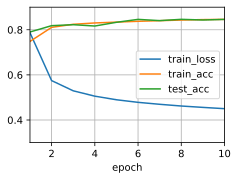

In [96]:
num_epochs, lr = 10, 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

#### 3.6.7 Prediction

Now that training is complete, our model is ready to classify some images. Given a series of images, we will compare their actual labels (first line of text output) and the model predictions (second line of text output).

In [100]:
def predict_ch3(net, test_iter, n = 6):
    for X,y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis = 1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape(n,28,28), 1, n, titles = titles[0:n])

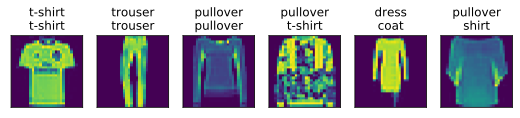

In [101]:
predict_ch3(net, test_iter)

With softmax regression, we can train models for multi-category classification. The training loop is very similar to that in linear regression: retrieve and read data, define models and loss functions, then train models using optimization algorithms. As you will soon find out, most common deep learning models have similar training procedures.

## 3.7 Concise Implementation of Softmax Regression

Just as Gluon made it much easier to implement linear regression, we will find it similarly (or possibly more) convenient for implementing classification models. Again, we begin with our import ritual.

In [102]:
import d2l
from mxnet import gluon, init, npx
from mxnet.gluon import nn

npx.set_np()

Let's stick with the Fashion-MNIST dataset and keep the batch size at 256 as in the last section.

In [103]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

#### 3.7.1 Initializing Model Parameters

As was mentioned in the previous section, the output layer of softmax regression is a fully-connected (`Dense`) layer. Therefore to implement our model, we just need to add one `Dense` layer with 10 outputs to our `Sequential`. Again, here, the `Sequential` is not really necessary, but we might as well form the habit since it will be ubiquitous when implementing deep models. Again, we initialize the weights at random with zero mean and standard deviation 0.01.

In [104]:
net = nn.Sequential()
net.add(nn.Dense(10))
net.initialize(init.Normal(sigma = 0.01))

In [105]:
net

Sequential(
  (0): Dense(-1 -> 10, linear)
)

#### 3.7.2 The Softmax

In the previous example, we calculated our model's output and then ran this output through the cross-entropy loss. Mathematically, that is a perfectly reasonable thing to do. **However, from a computational perspective, exponentiation can be a source of numerical stability issues. Recall that** $\hat{y_i} = \frac{exp(o_i)}{\sum{exp(o_j)}}$, where $\hat{y_j}$ is the $j^{th}$ element of `y_hat` and $z_j$ is the $j^{th}$ element of the input y_linear variable, as computed by the softmax. **If some of the $z_i$ are very large (i.e., very positive), then $e^{z_i}$ might be larger than the largest number we can have for certain types of `float` (i.e., overflow). This would make the denominator (and/or numerator) `inf` and we wind up encountering either 0, inf, or nan for $\hat{y_j}$**. In these situations we do not get a well-defined return value for cross_entropy. **One trick to get around this is to**:

- First subtract $max(z_i)$ from all $z_i$ before proceeding with the softmax calculation. You can verify that this shifting of each $z_i$ by constant factor does not change the return value of softmax.

- After the subtraction and normalization step, it might be possible that some $z_j$ have large negative values and thus the corresponding $e^{z_j}$ will take values close to zero. These might be rounded to zero due to finite precision (i.e. underflow), making $\hat{y_j}$ zero and giving us -inf for $log(\hat{y_j})$. A few steps down the road in backpropagation, we might find ourselves faced with a screenful of the dreaded not-a-number (nan) results.

Fortunately, we are saved by the fact that even though we are computing exponential functions, we ultimately **intend to take their log (when calculating cross-entropy). By combining these two operators (softmax and cross_entropy) together, we can escape the numerical instability that might otherwise plague us during backpropagation.** As shown in the equation below, we avoided calculating $e^{z_j}$ and can instead plug $z_j$ directly due to the cancelling in the log(exp(.)).

$log(\hat{y_j}) = log(\frac{e^{z_j}}{\sum{e^{z_i}}}) = log(e^{z_j}) - log(\sum(e^{z_i})) = z_j - log(\sum(e^{z_i}))$

We will want to keep the conventional softmax function handy in case we ever want to evaluate the probabilities output by our model. But instead of passing softmax probabilities into our new loss function, we will just pass the logits and compute the softmax and its log all at once inside the softmax_cross_entropy loss function, which does smart things like the log-sum-exp-trick

In [106]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

#### 3.7.3 Optimization Algorithm

Here, we use minibatch stochastic gradient descent with a learning rate of 0.1 as the optimization algorithm. Note that this is the same as we applied in the linear regression example and it illustrates the general applicability of the optimizers.

In [107]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

#### 3.7.4 Training

Next we call the training function defined in the last section to train a model.

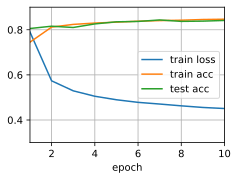

In [108]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [111]:
print(f'Accuracy of the model: {evaluate_accuracy(net, test_iter)}')

Accuracy of the model: 0.8413


As before, this algorithm converges to a solution that achieves an accuracy of around 84%, albeit this time with fewer lines of code than before. Note that in many cases, Gluon takes additional precautions beyond these most well-known tricks to ensure numerical stability, saving us from even more pitfalls that we would encounter if we tried to code all of our models from scratch in practice.